In [91]:
import ABC
import numpy as np
from Models import LinearModel, SIRModel
from scipy import stats

# silence warnings about dodgy division
np.seterr(divide='ignore', invalid='ignore')

# Size plots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [3]:
# print results
def print_results(results,num_stats=None):
    used=[]
    n=len(results)
    for x in returned_stats:
        if x not in used:
            used.append(x)
            print("([{}],{:.2f}%)".format(",".join([str(y) for y in x]),100*(returned_stats.count(x)/n)))
            
    if (num_stats):
        for i in range(num_stats):
            print("(ss_{},{:.2f}%)".format(i,100*(sum(i in row for row in returned_stats)/n)))

In [43]:
def estimate_r0(accepted_params,interval_width=.9):
    if (interval_width<=0) or (interval_width>=1): raise ValueError("`interval_width` must be in (0,1)")
    r0s=[beta/gamma for [_,_,beta,gamma] in accepted_params]
    
    lower_bound=(1-interval_width)/2
    upper_bound=1-lower_bound
    
    return np.quantile(r0s,lower_bound),np.quantile(r0s,upper_bound)

In [86]:
def mse(obs_1,obs_2):
    n_obs=len(obs_1)
    if (len(obs_2)!=n_obs): raise ValueError("obs_1 and obs_2 must have same dimension")
    sse=sum([(obs_1[i]-obs_2[i])**2 for i in range(n_obs)])
    return sse/n_obs

# Summary Statistics and ABC

A summary statistic $s(\cdot)$ is a projection of high-dimensional data to a lower dimension space.
$$ s:\mathbb{R}^m\to\mathbb{R}^p\text{ with }m>p $$
Sets of summary statistics $S=\{s_1,\dots,s_K\}$ are often applied to a data set, with each one capturing a different piece of information.
$$ S:\mathbb{R}^m\to\mathbb{R}^{\sum p_i}\text{ where }s_i:\mathbb{R}^m\to\mathbb{R}^{p_i}\text{ with }m>\sum p_i $$
It is common for datasets to be better represented by a matrix $\mathbb{R}^{n\times m}$ as they involve many observations, and each observation is multi-dimensional. In this case we want our summary statistics to map to dimensions $\{p_1,\dots,p_K\}$ st $n\times m\ll \sum p_i$.

Ideally, summary statistics are able to compress a dataset $D$ without compromising the information held within the dataset.

**Table of Contents**
 * [Motivation](#Motivation)
   * [Motivating Example](#motivating_example)
 * [Summary Statistics and ABC](#Summary-Statistics-in-ABC)
 * [Common Summary Statistics](#Common-Summary-Statistics)
 * [Theoretically Optimal Summary Statistics](#Theoretically-Optimal-Summary-Statistics)
 * [Properties of Summary Statistics](#Properties-of-Summary-Statistics)
   * [Sufficiency](#Sufficiency)
   * [Approximation Sufficiency](#Approximate-Sufficiency)
     * [Demonstration](#joyce_marjoram_demonstation)
 * [Summary Statistic Selection](#Summary-Statistic-Selection)
     * [Joyce & Marjoram](#Joyce-&-Marjoram)
     * [Minimising Entropy](#Minimising-Entropy)
     * [Two-Step Minimising Entropy](#Two-Step-Minimising-Entropy)
     * [(Semi-) Automatic ABC](#(Semi-)-Automatic-ABC)
     * [Non-Linear Projections](#Non-Linear-Projections)
     
 * [Dimensionality](#Dimensionality-for-SIR-Model)

## Motivation
In recent years there has been an explosion in the amount of data available. This is due to reduction in costs of computational power and storage, commercial interests, changes in societal opinion towards data collection and many other factors.

Larger datasets mean more computational power is required to run algorithms on them. Thus, being able to reduce the size of a dataset whilst still retaining most (if not all) of the meaningful information means the same analysis can be performed but require less resources.

The study of summarising large, complex data sets is a problem of interest in many different fields.

Approximate Bayesian Computation (ABC) methods are a class of algorithms for inferring model parameters given some observed data. ABC methods are computationally inefficient as they rely on simulations, thus they often require the use of summary statistics to be computationally tractable.

<a id="motivating_example"></a>
**Motivating Example**

Suppose you are given a dataset for the results of flipping a coin $X=\{H,H,T,T,H,T,T,T,T,T\}$ and you are tasked to determine whether the coin is biased or not. You may consider using two summary statistics:
 * The proportion of times heads occurs. $s_1(X)=3/10$.
 * The proportion of times tails occurs. $s_2(X)=7/10$.

Now you analysis only involves two data points $(s_1(X),s_2(X))$ rather than $|X|=10$. This approach also has the advantage the number of data points being analysed is fixed, whereas the size of the dataset $X$ could be variable.

This is obviously a very trivial example but it is easy to see how it can be extended to larger $X$s or multiple trials.

(TODO - use how RONA data is reported to demonstrate why different summary statistics are important for different problems).

## Summary Statistics in ABC
See [ABC_Notebook](ABC_Notebook.ipynb) for details on ABC methods and its implementation.

Approximate Bayesian Computation (ABC) methods are a class of algorithms for inferring model parameters given some observed data. ABC methods are computationally inefficient as they rely on simulations, thus they often require the use of summary statistics to be computationally tractable.

ABC methods infer model parameters by generating an approximation of the posterior for each parameter, given some observed data from the true model. The better the approximation, the better the resulting model fit should be. Summary statistics influence the quality of this approximation as reducing dimensionality of data will always worsen the approximation. Our task is to choose summary statistics such that this loss of information (or at least make worthwhile improvements to the computational effiency).

ABC methods involve comparing simulated data to observed data and determining how close the two sets are to each other. When these datasets have high-dimensionality it is less likely that they coincide due to the *curse of dimensionality*. Thus transforming these datasets with summary statistics makes it easier to compare them and should reduce the number of simulations required (or improve the quality of simulations kept).

Greater reduction in dimensionality means greater reduction in computation requirements but also greater level of approximation, likely meaning the produced posterior is less representative.

In ABC there are two sources of approximation-error: only requiring simulated data to be "similar to" rather than "equal to" the observed data; and comparing summaries of the simulated $S(X)$ and observed data $S(X_{obs})$, rather than comparing the raw simulated $X$ and observed data $X_{obs}$. An effective summary statistic should balance the trade-off of these two sources of error.

Theoretical results show that the optimal summary statistics are the posterior means for each parameter. These cannot be calculated directly but can be estimated through simulation.

In practice summary statistics often introduce unquantifiable bias (except by numerically comparing summary stats).

## Common Summary Statistics
Most good summary statistics consider the following properties
 * Centre of the data (e.g. mean, median).
 * Spread of the data (e.g. variance).
 * Shape of the data (e.g. skew).
 * Interdependence of data-fields (e.g. correlation).
 * Quantiles of the data
The reasons for this is explained below

## Theoretically Optimal Summary Statistics

Which summary statistic is best for determining the centre of a posterior distribution depends on the loss measure being used
 * Quadratic Loss = Mean
 * Absolute Loss = Median
 * All-or-Nothing (identity) Loss = Mode
 
**Proof** - *Mean minimises quadratic loss*

Define $L(\mathbf{y},x):=\sum_{i=1}^n(y_i-x)^2$ to be the quadratic loss between elements of vector $\mathbf{y}$ (some observed data) and target $x$. This definition can be expanded
$$\begin{array}{rcl}
    L(\mathbf{y},x)&=&\sum_{i=1}^n(y_i-x)^2\\
    &=&\sum_{i=1}^n(y_i^2-2y_ix+x^2)\\
    &=&\sum_{i=1}^ny_i-2x\sum_{i=1}^ny_i+\sum_{i=1}^nx^2\\
    &=&\sum_{i=1}^ny_i-2x\sum_{i=1}^ny_i+nx^2
\end{array}$$
We want to find the value of $x$ which minimises of this expression. Consider the first & second derivatives wrt $x$
$$\begin{array}{rcl}
    L'(\mathbf{y},\hat{x})&=&2n\hat{x}-2\sum_{i=1}^ny_i\\
    L''(\mathbf{y},\hat{x})&=&2n
\end{array}$$
Since $n\in\mathbb{N}$ then $2n>0$ and any solution to $L'=0$ will be a minimum.

Setting $L'$ to zero and rearranging to find $\hat{x}$ gives
$$ \hat{x}=\frac1n\sum_{i=1}^ny_i=\bar{\mathbf{y}} $$
This shows that quadratic loss is minimised when the target value is the mean of the "observed" data set.

*Comment*

For some models using logarithms makes sense (namely, epidemic models). Logarithms can be incorporated into the summary statistic or the distance measure.

## Properties of Summary Statistics

### Computational Efficiency

Generally, the performance of ABC-methods increases the more simulations they perform. Making implementations more computationally efficient decreases the time taken for each simulation and thus increases the number of simulations which can be completed in a fixed time-period (In practice, we specify how long an implementation runs for, not how many cycles). Choosing more computationally efficienct summary statistics will help with this.

For a model which outputs $n\times m$ data (ie $n$ readings each with $m$ features), most summary statistics have $O(mn)$ time-complexity theoretically (when being calculated for all features). However, in practice, there are intrinsic differences in the composition of each operation which affect their execution time:
 * Some summary stats require arithmetic computations (e.g. mean) whilst other comparision computations (e.g. min, max, median). 
 * Some summary stats require the computation of other summary statistics first (e.g. variance and pearson correlation require mean; Pearson's skewness requires variance and mean).

Some summary stats compare features and thus produce more than $m$ values (when applied to most combinations). For example, correlation between all features produces ${m\choose2}$ values and thus runs in $O({m\choose 2}n)$ time.

### Sufficiency
A statistic is said to be "sufficient" for a model if no other statistic provides more information about the model's parameters. This idea can be extended to sets of statistics (i.e. summary statistics).

Formally a set of statistics $S(\cdot)=(s_1(\cdot),\dots,s_K(\cdot))$ are said to be sufficient for the data $X\sim f(\cdot;\theta)$ if

$$ \mathbb{P}(X|S(X))=\mathbb{P}(X|S(X),\theta)) $$

This demonstrates that the summary statistics $S(X)$ capture all the information the data $X$ holds about the model parameters $\theta$. The summary statistics $S(\cdot)$ are a loss-less compresion of the data. (The likelihood of data $X$ given the summary statistic values $S(X)$ is independent of the model parameters $\theta$).

It is worth noting that if a set of statistics $S_{1:K-1}:=\{S_1,\dots,S_{K-1}\}$ are sufficient for $X$ then any super-set $S\supseteq S_{1:K-1}$ is also sufficient for $X$. This means that not only do we want to find a sufficient set of statistics, but also the smallest set (Minimum cardinality). Having a smaller set of statistics is desirable due to the computational efficiencies. (TODO proof)

### Approximate Sufficiency
In practice sufficient summary statistics do not always exist. Moreover, the Pitman–Koopman–Darmois Theorem states that sufficient statistics (whose dimension does not increase as sample size increase) only exist for models in the exponential family.

<!-- The concept of approximate sufficiency is a generalisation of sufficiency which can be applied to any statistical model and involves finding sets of statistics which capture a large amount of information from the sample. -->

Joyce & Marjoram introduce an approach to finding approximately sufficient statistics by building up a subset of statistics from a larger set. A statistic $S_K$ is added to the set $S_{1:K-1}=\{S_1,\dots,S_{K-1}\}$  if it is deemed to significantly increase the information extracted from the data $X$.

**Score $\delta_{K}$**

To determine the information gain from adding $S_K$ to the set $S$, first consider the following result from the product rule

$$\begin{array}{rrcl}
&\mathbb{P}(S_{1:K}(X)|\theta)&=&\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\mathbb{P}(S_{1:K-1}|\theta)\\
\implies&\ln\left\{\mathbb{P}(S_{1:K}(X)|\theta)\right\}&=&\ln\left\{\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\right\}+\ln\left\{\mathbb{P}(S_{1:K-1}|\theta)\right\}\\
\implies&\ln\left\{\mathbb{P}(S_{1:K}|\theta)\right\}-\ln\left\{\mathbb{P}(S_{1:K-1}|\theta)\right\}&=&\ln\left\{\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\right\}
\end{array}$$

This shows that $\ln\left\{\mathbb{P}(S_K(X)|S_{1:K-1},\theta)\right\}$ quantifies the information gained by adding $S_K$ to $S_{1:K-1}$. Thus, we want to find statistcs $S_K$ which maximise this quantity.

Joyrce & Marjoram propose the *Score* metric $\delta_{K}$, defined as
$$ \delta_{K}:=\sup_\theta\left\{\ln\left\{\mathbb{P}(S_K|S_{1:K-1},\theta)\right\}\right\}-\inf_\theta\left\{\ln\left\{\mathbb{P}(S_K|S_{1:K-1},\theta)\right\}\right\} $$

**$\varepsilon$-Approximate Sufficiency**

A set of statistics $S_{1:K-1}:=\{S_1,\dots,S_{K-1}\}$ is said to be $\varepsilon$-Sufficient relative to a statistic $S_K$ if the score of $S_K$ relative to the set $S_{1:K-1}$ is no-greater than $\varepsilon$.
$$\delta_K\leq\varepsilon$$
Note that this is equivalent to the definition of sufficiency when $S_K=X$ (identity function) and $\varepsilon=0$.

## Summary Statistic Selection
The most naive way to assess summary statistics is to visually inspect the plots when they are used.

### Joyce & Marjoram
Here are details on an approach, proposed by Joyce & Marjoram, to selecting summary statistics which uses the idea of approximate sufficiency.

**Algorithm**

Consider a large set of statistics $S:=\{S_1,\dots,S_N\}$ and fix some value for $\varepsilon\in\mathbb{R}^{\geq0}$. Here is the algorithm proposed by Joyce & Marjoram for finding an $\varepsilon$-sufficient subset $S^*$ of $S$, relative to the data set $X$.
<ol>
    <li>Define $S'=\emptyset$</li>
    <li>Calculate the score for statistic in $S_i\in (S\setminus S')$. See <a href="#approximating_score">below</a>.</li>
    <li>Identify the greatest score $\delta_{max}:=\max_{S_i\in S}\text{Score}(S_i,S')$.</li>
    <li>Identify a statistic which attains the greatest score $S_{max}\in\text{argmax}_{S_i\in S}\text{Score}(S_i,S')$.</li>
    <li>If $\delta_\text{max}>\varepsilon$ then add $S_{max}$ to $S'$ and return to step 2. Otherwise, stop the algorithm and return $S'$</li>
    $$S'=S'\cup S_{max}$$
    <li>When adding a new statistic, you should consider removing each summary statistic which has already been accepted so as to achieve the smallest set which is accepted.</li>
</ol>

**Variations**

This algorithm is deterministic when a deterministic method is used in step 4. However it runs in $O(N^K)$ time when $K$ summary statistics are chosen. There are variations on this algorithm which aim to improve the run-time, inc.
 * Calculate the score for each statistic in $S$ sequentially and if one below $\varepsilon$ then it is added to $S'$. (Rather than calculate score for all and chosing the maximum).
 * Remove $\varepsilon$ and instead find the best subset of size $K$.

**Implementation**
<a id="approximating_score"></a>

The main difficulty in implementing the algorithm above is in calculating the score $\delta_K$ for each statistic. Due to the nature of the problems which we are finding summary statistics for, we can only ever approximate the score $\delta_K$.

Joyce & Majoram replace the task of empirically estimating the score with the equivalent task of determining whether the odds-ratio differs from 1 more than would be expected from random noise.

Suppose you have a set of already accepted statistics $S_{1:K-1}:=\{S_1,\dots,S_{K-1}\}$ and are considering adding statistic $S_K$. Suppose a large set of parameters $\Theta$ have been generated and let $\Theta_{1:K-1},\ \Theta_{1:K}$ be the set of parameters where accepted when using $S_{1:K-1}$ and $S_{1:K}$ respectively.

Define $N_{K-1}:=|\Theta_{1:K-1}|,N_K:=|\Theta_{1:K}|$

<ol>
    <li>Discretise the sets of accepted parameter $\Theta_{1:K-1},\Theta_{1:K}$ into $M$ bins. Let $C_{1:K-1},C_{1:K}$ be these two sets of counts.</li>
    <li>Calculate the expected count for each bin $E=(N_K/N_{K-1})\cdot C_{1:K-1}$. </li>
    <li>Calculate the standard-variance for each bin $$sd=\sqrt{E\cdot\frac{N_{K-1}-C_{1:K-1}}{N_{K-1}}}$$. </li>
    <li>If any values in the counts from the proposed set $C_{1:K}$ is more than four standard deviations away from the expected counts then return that the proposed distribution is significantly different from the current (ie accepted $S_k$). Otherwise, accept don't accept the change in summary stats.</li>
</ol>

A big limitation of this approach is you can only determine whether two sets of summary stats produce notable different posteriors, and not whether one posterior is better than the other. This symmetry is an issue as it means it is as likely to replace a bad choice with a good choice as it is to replace a good choice with a bad choice.

Moreover, only being able to compare and not rank sets of statistics means the algorithm above needs to be largely reworked in practice.

**Demonstration**<a id="joyce_marjoram_demonstation"></a>

I have implemented the algorithm above as `ABC.joyce_marjoram()`. Here I demonstrate its usage by applying it to choosing a set of approximately sufficient summary statistics for a linear model $f(X)=1+10X+\varepsilon$ where $\varepsilon\sim\text{Normal}(0,30)$ and the start point is known. The only parameter which needs to be learnt is the gradient of the model. The mean difference gradient between consecutive data-points is a good estimator of the gradient of the model.

I supply the algorithm with the following three summary statistics
 * $S_0$ - Mean gradient.
 * $S_1$ - $U\sim\text{Uniform}[0,6]$. This range was chosen so the variance is similar to $S_0$.
 * $S_2$ - $S_1\cdot X$ where $X\sim\text{Uniform}[0,2]$

I ran the algorithm 25 times, each time generating 10,000 samples using a uniform acceptance-kernel with bandwidth 1 and discretising the posterior into 10 bins. The results can be seen below

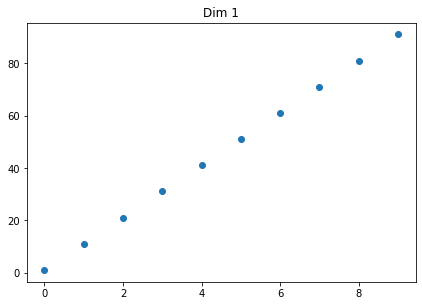

In [35]:
# define model
lm=LinearModel(  # 1+10x
    n_params=2,
    params=[1,10],
    n_vars=1,
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=0
    )
lm.plot_obs()

In [36]:
# define summary statistics
# Linear Model with known start point
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
rand=(lambda ys:[stats.uniform(0,6).rvs(1)[0]]) # variance set st similar number of samples accepted as mean_grad
rand_grad = (lambda ys:[mean_grad(ys)[0]*stats.uniform(0,2).rvs(1)[0]])
summary_stats=[mean_grad,rand,rand_grad]

In [5]:
%%time
# Choose summary statistics for Linear Model with known start point
param_bounds=[(1,1),(8,14)]
lm_priors_intersect_known=[stats.uniform(1,0),stats.uniform(8,6)]
returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats=ABC.joyce_marjoram(summary_stats,n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors_intersect_known,param_bounds=param_bounds,n_samples=10000,n_bins=10,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats)

24/25 [[1], [1], [0], [0], [1], [0], [0], [0], [0], [1], [0], [1], [1], [1], [0], [0], [1], [1], [0], [0], [0], [1], [0], [0]]

Results
([1],11)
([0],14)
Wall time: 36min 49s


*Comments*

This implementation settles on the set $\{S_0\}$ in most cases, which is the best set of statistics from those provided. It is dissapoint that it picks the completely random noise $S_1$ on five occassions but this is likely due to the setup of the acceptance kernel so could be reduced with tuning (or more samples).

In [8]:
%%time
# SIR model
sir_model=SIRModel(
    params=[100000,100,1,.5],
    n_obs=30,
    x_obs=[[x] for x in range(30)],)
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
param_bounds=[(100000,100000),(100,100),(0,1.5),(0,2)]

# logs taken so on similar scale
suscept_min_ss=(lambda ys:[np.log(ys[-1][0])])
removed_peak_ss=(lambda ys:[np.log(ys[-1][2])])
peak_infections_date_ss=(lambda ys:[ys.index(max(ys,key=lambda y:y[1]))])
peak_infections_value_ss=(lambda ys:[np.log(max(ys,key=lambda y:y[1])[1])])
rand=(lambda ys:[stats.uniform(0,19).rvs(1)[0]])
summary_stats=[removed_peak_ss,suscept_min_ss,peak_infections_date_ss,peak_infections_value_ss,rand]

returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats=ABC.joyce_marjoram(summary_stats,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,param_bounds=param_bounds,BANDWIDTH=4,n_samples=10000,n_bins=10,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats)

24/25 [[0], [2], [0], [2], [1], [0], [1], [1], [0], [1], [0], [0], [1], [2], [1], [0], [1], [0], [1], [1], [0], [2], [1], [1]]

Results
([0],9)
([2],4)
([1],12)
Wall time: 5min 27s


## Minimising Entropy

In *On Optimal Selection of Summary Statisticsfor Approximate Bayesian Computation* Nunes and Balding present an algorithm which seeks to find summary statistics which minimise entropy of the posterior.

**Entropy**

The Entropy $H(\cdot)$ of a probability distribution $X$ is a measure of the information in that distribution. Moreover, it is an average of the inherent information each outcome from the distribution carries about the values of the paramaters of the distribution.
$$
\begin{array}{rrcl}
\text{Discrete Distribution}&H(X)&:=&-\sum_{x\in\mathcal{X}}\mathbb{P}(X=x)\cdot\ln(\mathbb{P}(X=x))\\
\text{Continuous Distribution}&H(X)&:=&-\int_{\mathcal{X}}f_X(x)\ln(f_X(x))dx
\end{array}
$$

**Estimating Entropy**

There are several methods for estimating entropy, Nunes and Balding use the *$k^{th}$ Nearest-Neighbour Estimator of Entropy* as it performs well with multi-modal posteriors and is unbiased. They set $k=4$ (suggested by Singh et al. (2003)) due to its "error properties". Often the posterior is discretised to make calculation quicker.

$$\hat{H}=\ln\left(\frac{\pi^{p/2}}{\Gamma(1+\frac{p}2)}\right)-\frac{\Gamma'(k)}{\Gamma(k)}+\ln(n)+\frac{p}n\sum_{i=1}^n\ln R_{i,k}$$
where
 * $p=|\theta|$ - The number of parameters.
 * $R_{i,k}$ - The euclidean distance between the $i^{th}$ accepted parameter value and its $k^{th}$ nearest neighbour in the set of accepted parameters.
 * $n$ - Number of accepted parameters.

**Algorithm**

A lower entropy value implies greater information per observation. In ABC we want to maximise the information gained per sample, thus minimising the entropy of the generated posterior is a worthwhile goal. This is the gist of the algorithm proposed by Nunes and Balding
<ol>
    <li>Define a large set of summary statistics $S$.</li>
    <li>For each possible subset $S'\subseteq S$: </li>
    <ol>
        <li>Run ABC-Rejection using $S'$.</li>
        <li>Estimate the entropy of the generated posterior</li>
    </ol>
    <li>Return the set of statistics with the lowest estimated entropy.</li>
</ol>

**Extensions**

It is significantly easier to use the "best-samples" version of ABC-Rejection so the results are not dependend on the choice of kernel and bandwidth.

There are $2^{|S|}$ unique subsets of $S$, thus running the algorithm for all of these is inefficient (especially when $S$ has large cardinality). The simplest way to tackle this is only to consider subsets with cardinality less than some $n$. More compelx approaches involve use results from small subsets to determine whether to evaluate large subsets (pruning).

This approach only uses the entropy score $\hat{H}$ to find the best set of summary stats. Extensions could consider using it to rank them (or produce a probability distribution of them) and then a mixtures-model could be fitted with the summary statistics being chosen according to this ranking/distribution.

In [6]:
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
rand=(lambda ys:[stats.uniform(0,6).rvs(1)[0]]) # variance set st similar number of samples accepted as mean_grad
rand_grad = (lambda ys:[mean_grad(ys)[0]*stats.uniform(0,2).rvs(1)[0]])
summary_stats=[mean_grad,rand,rand_grad]

In [7]:
lm_priors=[stats.uniform(0,6),stats.uniform(8,6)]
lm_priors_intersect_known=[stats.uniform(1,0),stats.uniform(8,6)]

In [8]:
%%time
returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(summary_stats=summary_stats,n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors_intersect_known,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats)

24/25 [(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]

Results
([0],25)
Wall time: 23min 50s


*Comments*

Selects the best set of summary statistics in every scenario. Better than Joyce-Marjoram method of approximate sufficiency

In [37]:
%%time
# More summary stats
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
rand=(lambda ys:[stats.uniform(0,6).rvs(1)[0]]) # variance set st similar number of samples accepted as mean_grad
first=(lambda ys:ys[0])
first_last=(lambda ys:[ys[0][0],ys[-1][0]])
summary_stats=[mean_grad,rand,rand_grad,first,first_last]

returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(summary_stats=summary_stats,n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats)

24/25 [(0,), (0, 3, 4), (0, 3, 4), (0, 3, 4), (3, 4), (4,), (4,), (3, 4), (0,), (0, 3), (0, 3, 4), (0, 3), (0, 3), (4,), (0, 4), (0, 3), (0, 4), (0, 4), (0, 3), (0, 3), (0, 3, 4), (4,), (4,), (0, 3)]

Results
([0],2)
([0,3,4],5)
([3,4],2)
([4],5)
([0,3],7)
([0,4],3)
([3],1)
Wall time: 1h 46min 43s


*Comments*

| `mean_grad` | `rand` | `rand_grad` | `first` | `first_last` |
|-------------|--------|-------------|---------|--------------|
| 68% | 0% | 0% | 60% | 60% |

In [4]:
%%time
# SIR model
sir_model=SIRModel(
    params=[100000,100,1,.5],
    n_obs=30,
    x_obs=[[x] for x in range(30)],)
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]

# logs taken so on similar scale
suscept_min_ss=(lambda ys:[np.log(ys[-1][0])])
removed_peak_ss=(lambda ys:[np.log(ys[-1][2])])
peak_infections_date_ss=(lambda ys:[ys.index(max(ys,key=lambda y:y[1]))])
peak_infections_value_ss=(lambda ys:[np.log(max(ys,key=lambda y:y[1])[1])])
rand=(lambda ys:[stats.uniform(0,19).rvs(1)[0]])
summary_stats=[removed_peak_ss,suscept_min_ss,peak_infections_date_ss,peak_infections_value_ss,rand]

returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(summary_stats=summary_stats,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,max_subset_size=3,n_samples=10000,n_accept=1000,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats)

24/25 [(0, 2), (0, 3), (2, 3), (1, 2, 3), (0, 2, 3), (0, 1, 3), (1, 3), (1, 3), (0,), (0,), (0, 1), (0, 1, 2), (1,), (0, 2, 3), (0, 1, 3), (0, 3), (2, 3), (3,), (0, 2, 3), (0,), (0, 3), (0, 1, 3), (0, 2), (0, 2, 3)]

Results
([0,2],2)
([0,3],3)
([2,3],2)
([1,2,3],1)
([0,2,3],4)
([0,1,3],3)
([1,3],2)
([0],3)
([0,1],1)
([0,1,2],1)
([1],2)
([3],1)
Wall time: 2h 18min 47s


*Comments*

| `removed_peak_ss` | `suscept_min_ss` | `peak_infections_date_ss` | `peak_infections_value_ss` | `rand` |
|-------------------|------------------|---------------------------|----------------------------|--------|
| 68% | 40%| 40% | 64% | 0% |

## Two-Step Minimising Entropy

Nunes and Balding suggest a second approach to summary stastistic selection which extends upon their minimum entropy approach. This approach attempts to increase the pool of observed data by using $S_{ME}$ to find well fitting parameter values and treating these as if they were true. Their approach then runs ABC-Rejection Sampling with each subset of statistic, again, but now uses the [MRSS](#mrss) measure to compare each subset.

**RSS**

*Residual Sum of Squares (RSS)* is a measure of fit between a set of sequences $\{\theta_{sim,1},\dots,\theta_{sim,n}\}$ and some target sequence $\theta_{obs}$. Smaller RSS values indicate a tighter fit.
$$ RSS(\pmb\theta_{sim},\theta_{obs}):=\sqrt{\frac1n\sum_{i=1}^n||\theta_{sim,i}-\theta_{obs}\|} $$
<a id="mrss"></a>

RSS can be extended so different components of each sequence are weighted differently (I don't bother with that).

*Mean Residual Sum of Squares (MRSS)* is an extension of RSS which measures how similar two sets of sequences $\{\theta_{sim,1},\dots,\theta_{sim,n}\}$ \& $\{\theta_{obs_1,},\dots,\theta_{obs,m}\}$ are to each other. Smaller RSS values indicate a tighter fit.
$$ MRSS(\pmb\theta_{sim},\pmb\theta_{obs}):=\frac1m\sum_{j=1}^mRSS(\pmb\theta_{sim},\theta_{obs,j}) $$

**Algorithm**

<ol>
    <li>Use the <a url="#minimising-entropy">Minimising Entropy Algorithm</a> to find the set of summary statistics $S_{ME}$.</li>
    <li>Of the $n_{acc}$ parameter sets accepted during the ABC-Rejection Sampling step for $S_{ME}$ identify the $n_{best}$ of these which produce the best fitting outputs. Denote this set as $\{\theta_{obs,1},\dots,\theta_{obs,n_{best}}\}$.</li>
    <li>For each subset $S'$ of $S$:</li>
    <ol>
        <li>Run ABC-Rejection Sampling (Best Samples approach) using $S'$ and return the accepted parameter values $\{\theta_{acc,i},\dots,\theta_{acc,n_{acc}}\}$.</li>
        <li>Calculate MRSS</li>
        $$ MRSS=\frac1{n_{best}}\sum_{j=1}^{n_{best}}RSS(\pmb\theta_{acc},\theta_{best,j}) $$
    </ol>
    <li>Return the set of statistics which produced the lowest MRSS value.</li>
</ol>

**Extensions**

Again, the issue of the large number of possible subsets makes this algorithm inefficient. The same solutions as proposed in [Minimising-Entropy](#Minimising-Entropy) can be applied (a cap or pruning). An additional approach is to consider, which is in step 3. to only consider the subsets which performed "well" in step 1.


In [32]:
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
rand=(lambda ys:[stats.uniform(0,6).rvs(1)[0]]) # variance set st similar number of samples accepted as mean_grad
rand_grad = (lambda ys:[mean_grad(ys)[0]*stats.uniform(0,2).rvs(1)[0]])
summary_stats=[mean_grad,rand,rand_grad]

In [33]:
lm_priors_intersect_known=[stats.uniform(1,0),stats.uniform(8,6)]

In [34]:
%%time
returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.two_step_minimum_entropy(summary_stats=summary_stats,n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors_intersect_known,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats)

24/25 [(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]

Results
([0],25)
Wall time: 1h 4min 31s


In [9]:
%%time
# SIR model
sir_model=SIRModel(
    params=[100000,100,1,.5],
    n_obs=30,
    x_obs=[[x] for x in range(30)],)
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]

# logs taken so on similar scale
suscept_min_ss=(lambda ys:[np.log(ys[-1][0])])
removed_peak_ss=(lambda ys:[np.log(ys[-1][2])])
peak_infections_date_ss=(lambda ys:[ys.index(max(ys,key=lambda y:y[1]))])
peak_infections_value_ss=(lambda ys:[np.log(max(ys,key=lambda y:y[1])[1])])
rand=(lambda ys:[stats.uniform(0,19).rvs(1)[0]])
summary_stats=[removed_peak_ss,suscept_min_ss,peak_infections_date_ss,peak_infections_value_ss,rand]

returned_stats=[]
n_tests=25

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.two_step_minimum_entropy(summary_stats=summary_stats,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats)

24/25 [(1, 2, 3), (0, 1, 2, 3), (0, 1, 2, 3), (0, 3), (0, 3), (0, 3), (0, 1, 2), (0, 1), (1, 2, 3), (0, 3), (0, 3), (1, 2, 3), (0,), (0, 1, 2, 3), (0, 1), (0, 3), (1, 2, 3), (0, 3), (1, 2, 3), (0, 1), (1, 2, 3), (0, 1, 2, 3), (0, 1, 2, 3), (1, 2, 3)]

Results
([1,2,3],7)
([0,1,2,3],5)
([0,3],7)
([0,1,2],1)
([0,1],3)
([0],1)
([1,3],1)
Wall time: 19min 48s


*Comments*

| `removed_peak_ss` | `suscept_min_ss` | `peak_infections_date_ss` | `peak_infections_value_ss` | `rand` |
|-------------------|------------------|---------------------------|----------------------------|--------|
| 68% | 68%| 52% | 80% | 0% |

## (Semi-) Automatic ABC

In *Constructing summary statistics for approximate Bayesian computation: semi-automatic approximate Bayesian computation* Fearnhead and Prangle suggest an approach they call Semi-Automatic ABC. This approach involves a pilot run of ABC which is used to construct summary statistics, which are then used to fit the model in the second run of ABC.

This method is called "Semi-Automatic" as the specification of the created summary statistics does rely on simulated values, but is only "Semi" as we still "arbitrarly" specify parts of the creation process (e.g. $f(\cdot)$ below and the priors & summary stats during the pilot ABC run).

<a id="semi_auto_abc_create"></a>
**Creating Summary Statistics**

Theoretical analysis shows that the posterior mean of each parameter is the optimal summary statistic. However, this value cannot  be calculated and in practice other techniques need to be used. Posterior means are the optimal statistics when trying to minimise quadratic loss, thus finding statistics which do this is an optimal strategy.

Fearnhead and Pangle suggest that "Lasso" (Hastie et al. 2001) and "Canonical Correlation Analysis" (Mardia et al. 1979) are valid methods, but ultimately determine that least-squares linear regression is best as it performs just as well and it easy to implement.

Linear regression is applied to each parameter independely and least-squares is used to find $\hat\beta_0^{(i)},\hat{\pmb\beta}_1^{(i)}$ which best fit the following linear expression
$$ \theta_i=\mathbb{E}[\theta_i|D]+\varepsilon_i=\beta_0^{(i)}+\pmb\beta_1^{(i)}f(D)+\varepsilon_i $$
where $\theta_i$ is the $i^{th}$ parameter, $D$ is output data from the model when $\theta_i$ is used (We generate $M$ $(\theta_i,D)$ pairs in the algorithm and $f(\cdot)$ is a transformation (possibly non-linear).

Note that $\pmb\beta_1^{(i)}$ is a vector of the same dimension of $f(D)$, meaning $\pmb\beta_1^{(i)}f(D)$ is a weighted sum.

The simplest choice for transform $f(\cdot)$ is the identity function $f(x)=x$ but in practice different transformations may be found to be more effective such as using logarithms to make an exponential model linear.

The summary statistic for each parameter $\theta_i$ is
$$S_i(D)=\hat{\pmb\beta}_1^{(i)}f(D)$$
The constant term $\hat\beta_0$ is dropped as ABC only every compares the difference between summary statistic values.

**Algorithm**

<ol>
    <li>Perform a pilot run of ABC using arbitratily chosen summary statistics. Let $F$ be the posterior generated for the parameters.</li>
    <li>Generate $M$ sets of parameters from $F$ and simulated model outputs for each set. This creates a set of $M$ parameter-data pairs $(\theta_i,D_i)$.</li>
    <li>Use the simulated data $\{(\theta_{sim,1},D_1),\dots,(\theta_{sim,M},D_M)\}$ to create a set of summary statistics $S$. (See <a href="#semi_auto_abc_create">Above</a> for possible methods). </li>
    <li>Return $S$.</li>
</ol>

**Extensions**

Step 1. is purely require to find a region in the parameter space with non-neglible posterior mass and thus can be skipped if our priors are already informative.

When running ABC using the creates summary stats $S$, the priors used to be truncated such that they don't exceed the range of the posterior generated in step 1.

**Limitations**

See https://spiral.imperial.ac.uk/bitstream/10044/1/71280/2/1201.1314v1.pdf

Assumes a linear relationship between each parameter and the outcomes.

Due to the summary statistics being generated automatically you cannot have an intuition for how to set the bandwidth $\varepsilon$ for the acceptance kernels. This can be combatted by using the "Best Fits" version of ABC-Rejection rather than ABC-MCMC or ABC-SMC but this is clearly undersirable. Alternatively another pilot, or use of the simulations generated in the pilot run could be used to determine a suitable bandwidth.

**Note** The generated summary statistics maps the data from $\mathbb{R}^{N\times M}$ to $\mathbb{R}^{1\times M}$. This is a very dimension reduction and is intuitively appealing as there is a single summary statistics for parameter. If each parameter is independent then this is an optimal reduction, however, in practice, parameters are not independent.

**Advantages**

Why not just use the simulations from the pilot experiment to make predictions on parameter values

**Implementation**



In [2]:
sir_model=SIRModel(
    params=[100000,100,1,.5],
    n_obs=30,
    x_obs=[[x] for x in range(30)],)
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]

In [3]:
def estimate_r0(accepted_params,interval_width=.9):
    if (interval_width<=0) or (interval_width>=1): raise ValueError("`interval_width` must be in (0,1)")
    r0s=[beta/gamma for [_,_,beta,gamma] in accepted_params]
    
    lower_bound=(1-interval_width)/2
    upper_bound=1-lower_bound
    
    return np.quantile(r0s,lower_bound),np.quantile(r0s,upper_bound)

In [12]:
%%time
np.random.seed(16111998) # Fix random seed
summary_stats,_=ABC.abc_semi_auto(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,distance_measure=ABC.log_l2_norm,n_pilot_samples=50000,n_pilot_acc=500,n_params_sample_size=500)
s_obs=[s(sir_model.observe()) for s in summary_stats]
print(s_obs)

Calculated posteriors from pilot.                
Generated 500 parameter sets.
Generated summary statistics
[[78.66815931676676, 0.7353951785345756, 784555893158.7878, 103739705765.60745]]
Wall time: 1min 1s


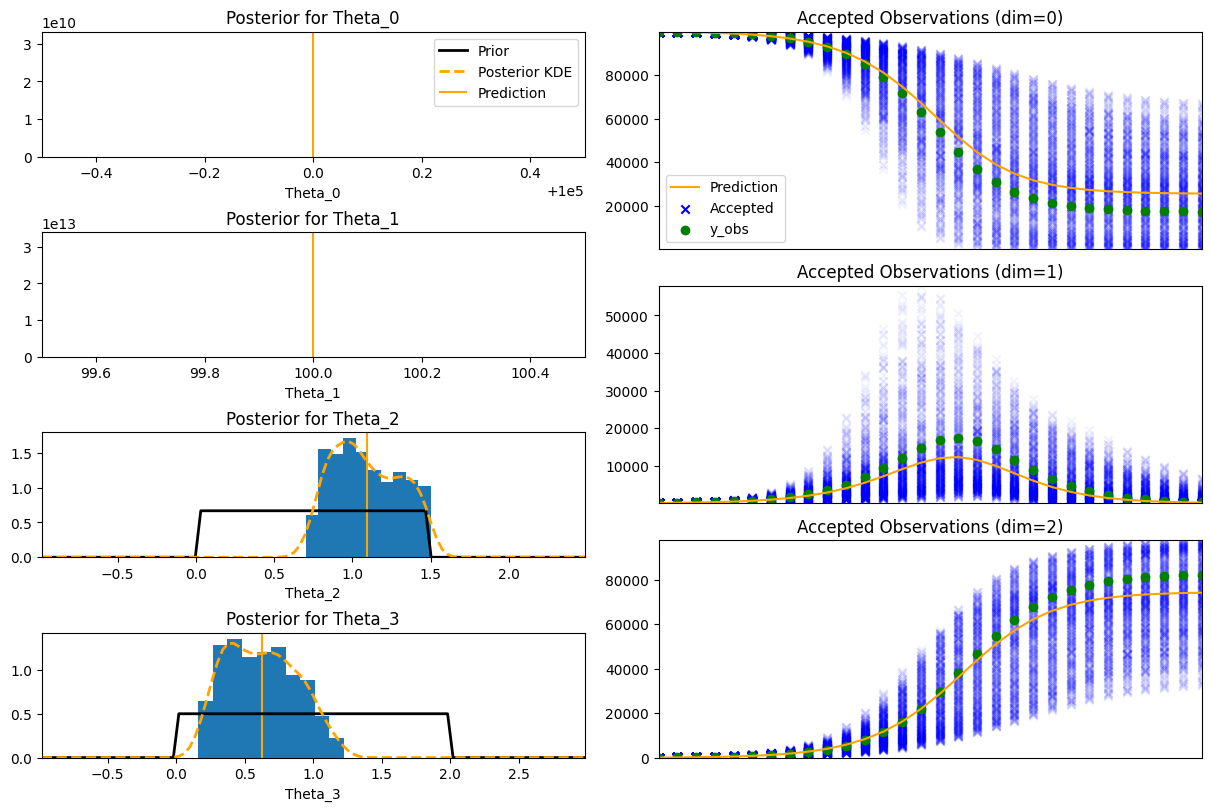

Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.092
Gamma=0.625
R_0=1.749
R0 - [1.304,3.674]
Wall time: 11.9 s


In [13]:
%%time
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":5000,"sample_size":500,"distance_measure":ABC.log_l2_norm}
fitted_model,accepted_params=ABC.abc_rejcection(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("Fitted Model - {}".format(fitted_model))

# 90% CI for R0 value
r0_estimate=estimate_r0(accepted_params)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate[0],r0_estimate[1]))

Found Start - (3) [100000.0, 100.0, 1.1326642379491212, 0.5195175926685265]
0.439 observations were new.


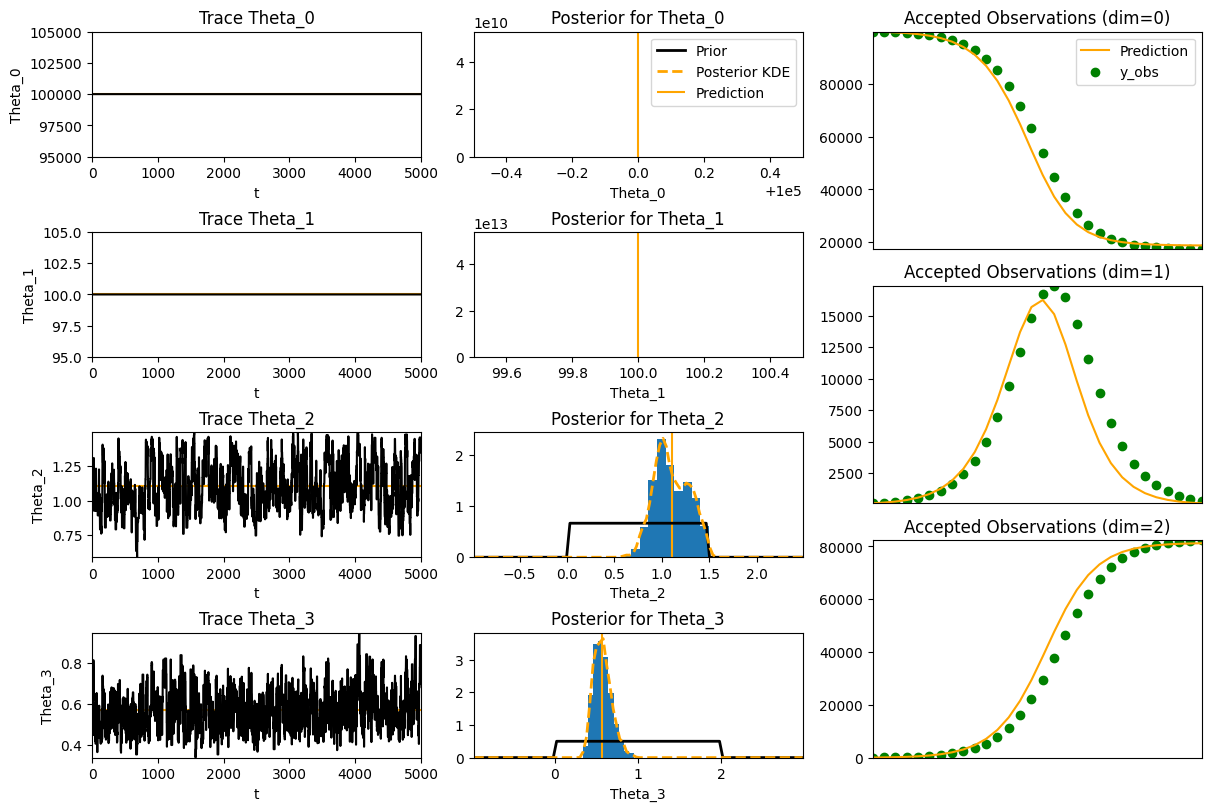

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
R_0=2.000

Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.105
Gamma=0.571
R_0=1.935
R0 - [1.304,3.674]
Wall time: 19 s


In [16]:
%%time
np.random.seed(16111998) # Fix random seed

perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2
fitted_model,_=ABC.abc_mcmc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,
    chain_length=5000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.gaussian_kernel,scaling_factor=50,summary_stats=summary_stats)
print("True Model - {}\n".format(sir_model))
print("Fitted Model - {}".format(fitted_model))

# 90% CI for R0 value
r0_estimate=estimate_r0(accepted_params)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate[0],r0_estimate[1]))

## Non-Linear Projections

Neural networks and deep learning techniques have been used to model the relationship between parameter values and summary statistics.

In *Learning Summary Statistics For Approximate Bayesian Coputation Via Deep Neural Networks* Jiang, Wu, Zheng and Hong explore automating the summary statistic selection process by using trained DNNs as summary statistics rather than theoretically motivated summary statistics. One DNN is used per model parameter and the network is targetting the posterior mean. A large limitation is that of DNNs overfitting, but there are standard methods to combat this (have lots of training data relative to num params; regularisation).

*Marin et. al ('16)* used random forests to combine summary statistics. The idea being to use several summary statistics to produce a good estimate of the posterior mean.

# Dimensionality for SIR Model

For the SIR model used above, the identity function produces a summary statistic with $3\times30=90$ dimensions. Here I use the methods above to find the best summary stats at different level of dimensionality and then plot the MSE each set produces against their dimensionality in order to find the optimal dimensionality.



In [4]:
sir_model=SIRModel(
    params=[100000,100,1,.5],
    n_obs=30,
    x_obs=[[x] for x in range(30)],)
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
param_bounds=[(100000,100000),(100,100),(0,1.5),(0,2)]
# sir_model.plot_obs()

In [99]:
# SUMMARY STATISTICS
# scaled to be similiar to peak_infections_date
final_susceptible_ss=(lambda ys:[2*np.log(ys[-1][0])]) # size of final populations
final_infectious_ss=(lambda ys:[3*np.log(ys[-1][1])])
final_removed_ss=(lambda ys:[1.5*np.log(ys[-1][2])])

peak_infections_date_ss=(lambda ys:[ys.index(max(ys,key=lambda y:y[1]))]) # date of peak infectious size
peak_infections_value_ss=(lambda ys:[1.5*np.log(max(ys,key=lambda y:y[1])[1])]) # peak infectious population size

net_weekly_susceptible_ss=(lambda ys:[.5*np.log(abs(ys[i][0]-ys[i-7][0])) for i in range(7,len(ys)-1,7)]) # weekly change in susceptible (dim=3)
net_weekly_infections_ss=(lambda ys:[.5*np.log(abs(ys[i][1]-ys[i-7][1])) for i in range(7,len(ys)-1,7)]) # weekly change in infections (dim=3)
net_weekly_removed_ss=(lambda ys:[.5*np.log(abs(ys[i][2]-ys[i-7][2])) for i in range(7,len(ys)-1,7)])

net_daily_susceptible_ss=(lambda ys:[0.08*np.log(abs(ys[i+1][0]-ys[i][0])) for i in range(0,len(ys)-1)]) # daily change in susceptible (dim=29)
net_daily_infections_ss=(lambda ys:[0.1*np.log(abs(ys[i+1][1]-ys[i][1])) for i in range(0,len(ys)-1)]) # daily change in infections (dim=29)
net_daily_removed_ss=(lambda ys:[0.08*np.log(abs(ys[i+1][2]-ys[i][2])) for i in range(0,len(ys)-1)])

mean_susceptible_ss=(lambda ys:[1.6*np.log(np.mean([y[0] for y in ys]))])
mean_infectious_ss=(lambda ys:[2*np.log(np.mean([y[1] for y in ys]))])
mean_removed_ss=(lambda ys:[1.6*np.log(np.mean([y[2] for y in ys]))])

rand=(lambda ys:[stats.uniform(0,19).rvs(1)[0]]) # random

summary_stats=[final_susceptible_ss,final_infectious_ss,final_removed_ss, #0,1,2
                peak_infections_date_ss,peak_infections_value_ss, # 3,4
                net_weekly_susceptible_ss,net_weekly_infections_ss,net_weekly_removed_ss, #5,6,7
                net_daily_susceptible_ss,net_daily_infections_ss,net_daily_removed_ss, #8,9,10
                mean_susceptible_ss,mean_infectious_ss,mean_removed_ss, #11,12,13
                rand,] #14

summary_stats_size_one=[final_susceptible_ss,final_infectious_ss,final_removed_ss, #0,1,2
                peak_infections_date_ss,peak_infections_value_ss, #3,4
                mean_susceptible_ss,mean_infectious_ss,mean_removed_ss, #5,6,7
                rand,]#8

good_summary_stats_size_one=[final_removed_ss, #0
                peak_infections_date_ss, #1
                mean_susceptible_ss,mean_infectious_ss,mean_removed_ss, #2,3,4
                ]

summary_stats_size_four=[net_weekly_susceptible_ss,net_weekly_infections_ss,net_weekly_removed_ss,]

summary_stats_size_tweenty_nine=[net_daily_susceptible_ss,net_daily_infections_ss,net_daily_removed_ss,]

**Minimum-Entropy**

In [5]:
%%time
# Set-Size=1
returned_stats=[]
n_tests=50

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(summary_stats_size_one,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,n_samples=10000,n_accept=1000,
                                     min_subset_size=1,max_subset_size=1,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats,len(summary_stats_size_one))

49/50 [(6,), (4,), (0,), (4,), (5,), (5,), (7,), (4,), (5,), (2,), (7,), (4,), (6,), (2,), (5,), (5,), (6,), (5,), (5,), (0,), (7,), (7,), (5,), (4,), (2,), (4,), (7,), (5,), (6,), (4,), (6,), (4,), (6,), (7,), (4,), (4,), (2,), (5,), (7,), (4,), (4,), (5,), (2,), (2,), (4,), (4,), (2,), (6,), (2,)]

Results
([6],14.00%)
([4],28.00%)
([0],4.00%)
([5],24.00%)
([7],14.00%)
([2],16.00%)
(ss_0,4.00%)
(ss_1,0.00%)
(ss_2,16.00%)
(ss_3,0.00%)
(ss_4,28.00%)
(ss_5,24.00%)
(ss_6,14.00%)
(ss_7,14.00%)
(ss_8,0.00%)
Wall time: 58min 40s


In [8]:
%%time
# Set-Size=2
returned_stats=[]
n_tests=50

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(good_summary_stats_size_one,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,n_samples=10000,n_accept=1000,
                                     min_subset_size=2,max_subset_size=2,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats,len(summary_stats_size_one))

49/50 [(0, 2), (0, 3), (2, 3), (0, 2), (0, 3), (1, 2), (0, 4), (3, 4), (3, 4), (3, 4), (3, 4), (1, 4), (1, 4), (1, 4), (3, 4), (3, 4), (3, 4), (0, 2), (0, 4), (1, 4), (0, 2), (0, 3), (1, 4), (1, 4), (0, 1), (1, 4), (1, 4), (0, 1), (0, 4), (3, 4), (0, 2), (0, 2), (0, 3), (1, 4), (3, 4), (3, 4), (0, 1), (3, 4), (0, 1), (0, 1), (0, 2), (0, 3), (3, 4), (0, 3), (2, 4), (0, 3), (0, 2), (3, 4), (0, 2)]

Results
([0,2],18.00%)
([0,3],14.00%)
([2,3],2.00%)
([1,2],2.00%)
([0,4],6.00%)
([3,4],26.00%)
([1,4],18.00%)
([0,1],10.00%)
([2,4],2.00%)
([1,3],2.00%)
(ss_0,48.00%)
(ss_1,32.00%)
(ss_2,24.00%)
(ss_3,44.00%)
(ss_4,52.00%)
(ss_5,0.00%)
(ss_6,0.00%)
(ss_7,0.00%)
(ss_8,0.00%)
Wall time: 1h 20s


In [9]:
%%time
# Set-Size=3
returned_stats=[]
n_tests=50

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(good_summary_stats_size_one,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,n_samples=10000,n_accept=1000,
                                     min_subset_size=3,max_subset_size=3,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats,len(good_summary_stats_size_one))

49/50 [(2, 3, 4), (1, 3, 4), (1, 3, 4), (2, 3, 4), (0, 1, 4), (0, 1, 3), (0, 1, 2), (0, 1, 3), (1, 2, 4), (0, 2, 3), (0, 2, 3), (0, 1, 2), (1, 2, 4), (0, 2, 3), (0, 2, 3), (0, 1, 4), (0, 1, 4), (0, 3, 4), (1, 2, 3), (0, 2, 4), (0, 1, 2), (1, 3, 4), (0, 3, 4), (1, 3, 4), (0, 1, 4), (0, 2, 3), (1, 3, 4), (0, 2, 3), (0, 1, 4), (0, 1, 2), (0, 2, 4), (0, 3, 4), (2, 3, 4), (0, 1, 2), (0, 2, 3), (1, 2, 3), (1, 3, 4), (0, 3, 4), (1, 2, 3), (0, 1, 4), (0, 2, 4), (0, 1, 4), (0, 2, 4), (1, 2, 3), (2, 3, 4), (0, 2, 3), (2, 3, 4), (0, 2, 3), (0, 2, 3)]

Results
([2,3,4],10.00%)
([1,3,4],12.00%)
([0,1,4],14.00%)
([0,1,3],6.00%)
([0,1,2],10.00%)
([1,2,4],4.00%)
([0,2,3],20.00%)
([0,3,4],8.00%)
([1,2,3],8.00%)
([0,2,4],8.00%)
(ss_0,66.00%)
(ss_1,54.00%)
(ss_2,60.00%)
(ss_3,64.00%)
(ss_4,56.00%)
Wall time: 1h 1min 41s


In [10]:
%%time
# Set-Size=4a
returned_stats=[]
n_tests=50

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(summary_stats_size_four,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,n_samples=10000,n_accept=100,
                                     min_subset_size=1,max_subset_size=1,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats,len(summary_stats_size_four))

49/50 [(2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (1,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,)]

Results
([2],98.00%)
([1],2.00%)
(ss_0,0.00%)
(ss_1,2.00%)
(ss_2,98.00%)
Wall time: 6min 38s


In [ ]:
%%time
# Set-Size=4b
returned_stats=[]
n_tests=50

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\r")
    best_stats,_=ABC.minimum_entropy(good_summary_stats_size_one,n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,n_samples=10000,n_accept=1000,
                                     min_subset_size=4,max_subset_size=4,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")

In [7]:
returned_stats=[(0, 1, 2, 4), (0, 1, 2, 3), (1, 2, 3, 4), (0, 1, 3, 4), (0, 1, 3, 4), (1, 2, 3, 4), (1, 2, 3, 4), (0, 2, 3, 4), (0, 1, 2, 4), (0, 2, 3, 4), (0, 2, 3, 4), (0, 1, 2, 3), (0, 1, 2, 4), (1, 2, 3, 4), (0, 1, 2, 4), (0, 2, 3, 4), (0, 1, 2, 4), (0, 2, 3, 4), (0, 1, 2, 3), (0, 2, 3, 4), (1, 2, 3, 4), (0, 2, 3, 4), (0, 1, 2, 4)]
print_results(returned_stats,len(good_summary_stats_size_one))

([0,1,2,4],26.09%)
([0,1,2,3],13.04%)
([1,2,3,4],21.74%)
([0,1,3,4],8.70%)
([0,2,3,4],30.43%)
(ss_0,78.26%)
(ss_1,69.57%)
(ss_2,91.30%)
(ss_3,73.91%)
(ss_4,86.96%)


# Summary Stats on Partial Data

In [52]:
# fit a model using on the first `n_days` of time-series
def fit_truncated_model(model,n_days):
    trun_model=model.copy(model.params)

    trun_model.x_obs=[[i] for i in range(n_days)]
    trun_model.observations=trun_model._calc(trun_model.x_obs)

    sir_smc_priors=[stats.uniform(100000,1),stats.uniform(100,1),stats.uniform(0,2.5),stats.uniform(0,1.5)]

    fitted_model,accepted_params,weights=ABC.adaptive_abc_smc(n_obs=n_days,y_obs=trun_model.observe(),
        fitting_model=trun_model.copy([1,1,1,1]),priors=sir_smc_priors,
        max_steps=100,sample_size=50,max_simulations=3500,
        acceptance_kernel=ABC.uniform_kernel,alpha=.9,
        summary_stats=None,
        distance_measure=ABC.log_l2_norm,show_plots=True,printing=False)

    return fitted_model,accepted_params,weights

************************************************

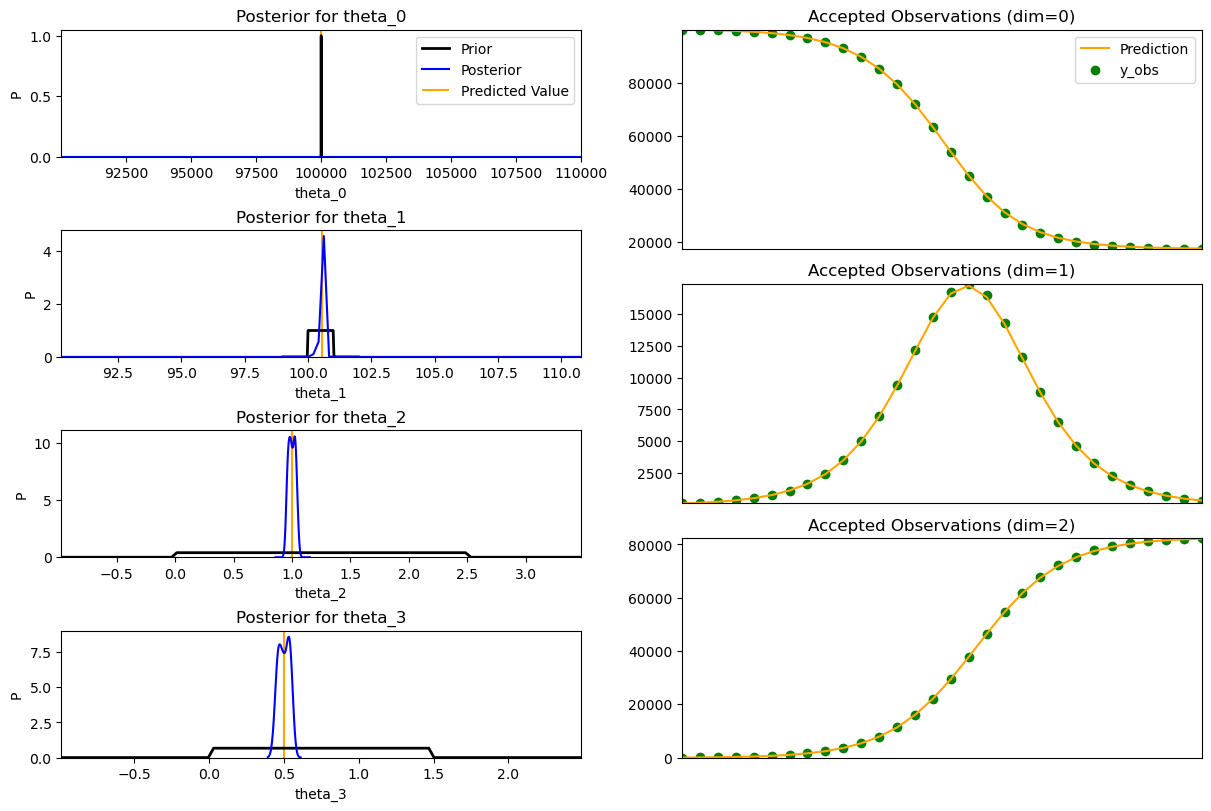

Wall time: 4min 30s


In [81]:
%%time
fitted_model_30,accepted_params_30,weights_30=fit_truncated_model(sir_model,30)

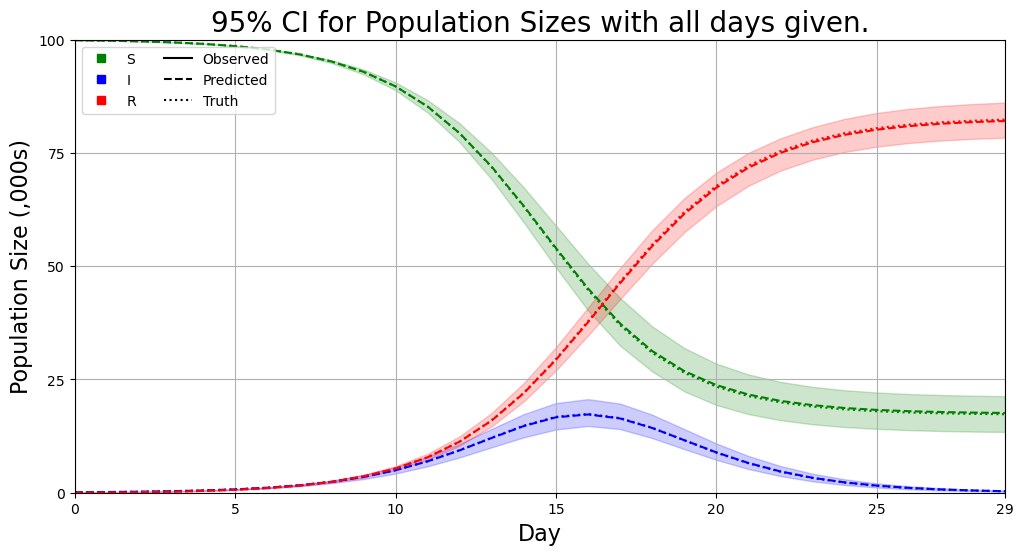

95% CI for R0: [1.871,2.170]


In [106]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_model_projection(ax,sir_model,1,accepted_params_30,weights_30,alpha=.05)
ax.set_title("95% CI for Population Sizes with all days given.",fontsize=20)

plt.grid()
plt.show()

r0_ci=estimate_r0(accepted_params_30,interval_width=.95)
print("95% CI for R0: [{:.3f},{:.3f}]".format(r0_ci[0],r0_ci[1]))

******************************************************

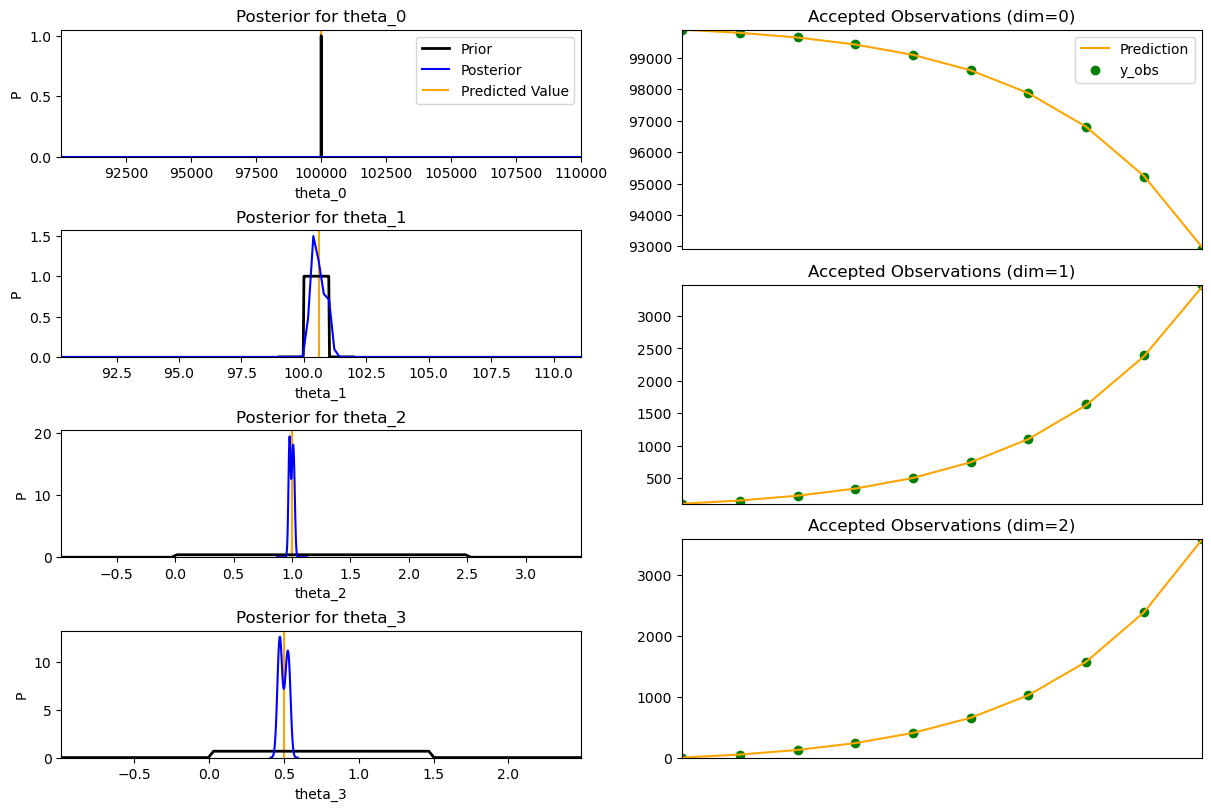

Wall time: 4min 59s


In [53]:
%%time
fitted_model_10,accepted_params_10,weights_10=fit_truncated_model(sir_model,10)

**********************************************

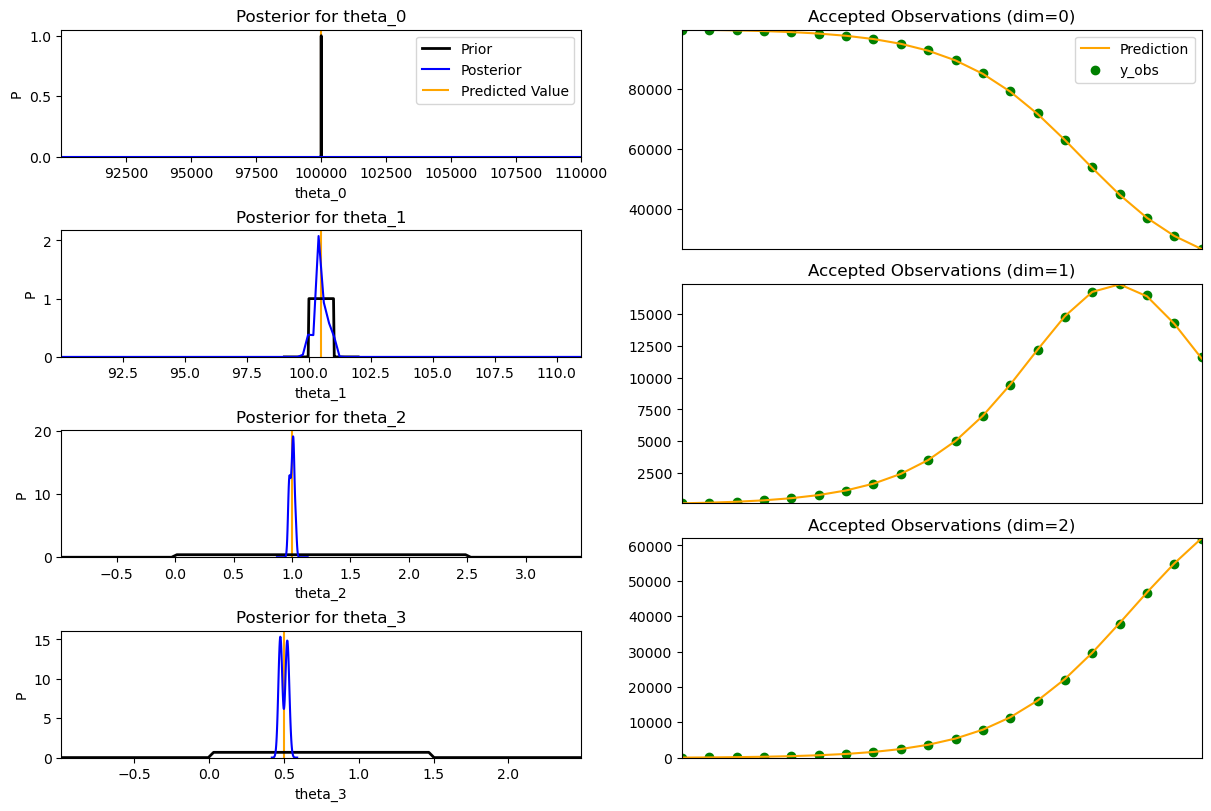

Wall time: 4min 18s


In [54]:
%%time
fitted_model_20,accepted_params_20,weights_20=fit_truncated_model(sir_model,20)

In [55]:
import matplotlib.pyplot as plt

In [56]:
# plot of model projection with confidence intervals
def plot_model_projection(ax,true_model,n_days,accepted_params,weights,alpha=0.05,legend=True):
    xs=true_model.x_obs
    ys=true_model.observe()
    obs=[]
    
    for _ in range(1000):
        ind=np.random.choice(len(accepted_params),size=1,p=weights)
        params=accepted_params[ind[0]]
        temp_model=true_model.copy(params)
        new_obs=temp_model.observe()
        obs.append(new_obs)
    
    x_preds=xs[n_days-1:]
    
    # Plot true given data
    ax.plot(xs[:n_days],[y[0] for y in ys[:n_days]],c="green") # label="Observed S"
    ax.plot(xs[:n_days],[y[1] for y in ys[:n_days]],c="blue") # label="Observed I"
    ax.plot(xs[:n_days],[y[2] for y in ys[:n_days]],c="red",) # label="Observed R"
    
    # Plot true future data
    ax.plot(xs[n_days-1:],[y[0] for y in ys[n_days-1:]],c="green",ls=":") # label="True S"
    ax.plot(xs[n_days-1:],[y[1] for y in ys[n_days-1:]],c="blue",ls=":") #label="True I"
    ax.plot(xs[n_days-1:],[y[2] for y in ys[n_days-1:]],c="red",ls=":") # label="True R"
    
    # Calculate & Plot Predictions
    means=[]
    upper_bounds=[]
    lower_bounds=[]
    
    for i in range(n_days-1,true_model.n_obs):
        y_is=[o[i] for o in obs]
        
        mean=np.mean(y_is,axis=0)
        ub=np.percentile(y_is,100*(1-alpha/2),axis=0)
        lb=np.percentile(y_is,100*(alpha/2),axis=0)
        
        means+=[mean]
        upper_bounds+=[ub]
        lower_bounds+=[lb]
    
    y_min=0
    y_max=true_model.population_size
    
    # S
    i=0
    ax.plot(x_preds,[m[i] for m in means],c="green",ls="--") # label="Predicted S"
    ax.fill_between([x[0] for x in x_preds],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                   ,color="green",alpha=.2)
    
    # I
    i=1
    ax.plot(x_preds,[m[i] for m in means],c="blue",ls="--") # label="Predicted I"
    ax.fill_between([x[0] for x in x_preds],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                   ,color="blue",alpha=.2)
    
    # R
    i=2
    ax.plot(x_preds,[m[i] for m in means],c="red",ls="--") # label="Predicted R"
    ax.fill_between([x[0] for x in x_preds],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                   ,color="red",alpha=.2)
    
    # make legend
    if (legend):
        f = lambda m,l,c: plt.plot([],[], marker=m,color=c,ls=l)[0]
        handles = [f("s","",c) for c in ["green","blue","red"]]
        handles+= [f(None,l,"black") for l in ["-","--",":"]]

        ax.legend(handles=handles,labels=["S","I","R","Observed","Predicted","Truth"],loc="upper left",ncol=2)
    
    ax.set_title("{}% CI for Population Sizes with {} days given.".format(int(100*(1-alpha)),n_days),fontsize=20)

    ax.set_xlabel("Day",fontsize=16)
    ax.set_ylabel("Population Size (,000s)",fontsize=16)

    ax.set_xticks(list(range(0,max(xs,key=lambda x:x[0])[0],5))+[29])
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.set_yticklabels(["{:,.0f}".format(x//1000) for x in np.linspace(0, y_max, 5)])

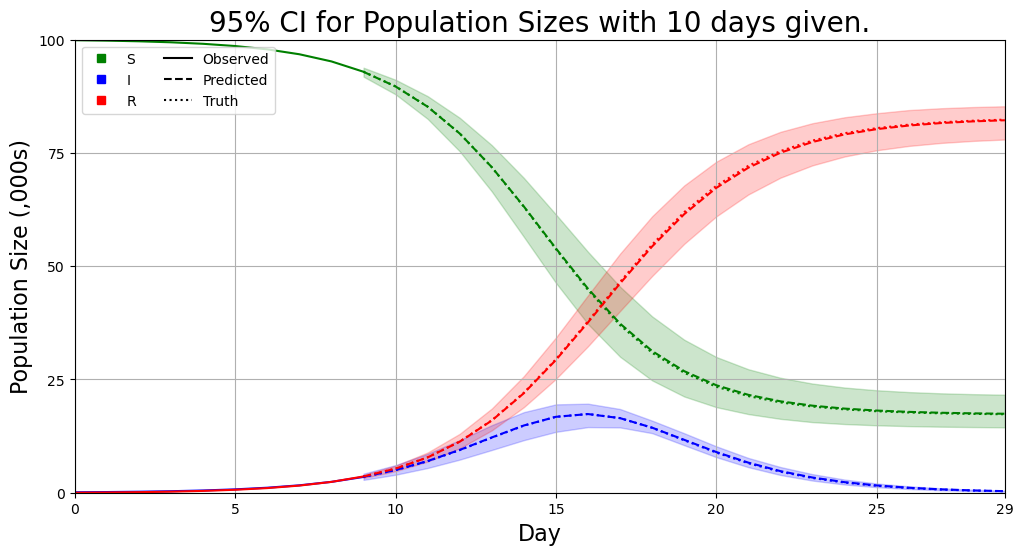

95% CI for R0: [1.544,3.071]


In [96]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_model_projection(ax,sir_model,10,accepted_params_10,weights_10,alpha=.05)

plt.grid()
plt.show()

r0_ci=estimate_r0(accepted_params_semi_10,interval_width=.95)
print("95% CI for R0: [{:.3f},{:.3f}]".format(r0_ci[0],r0_ci[1]))

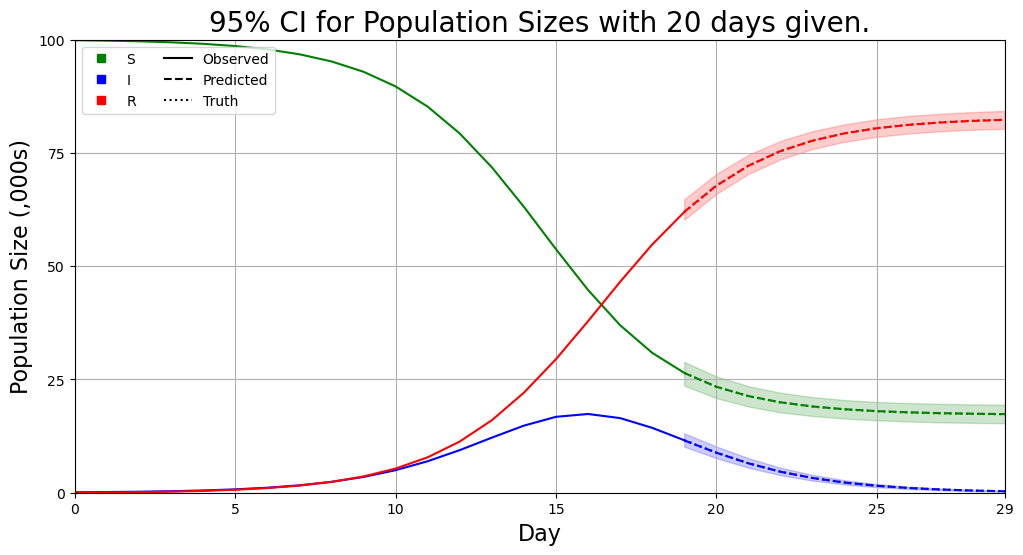

95% CI for R0: [1.924,2.080]


In [95]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_model_projection(ax,sir_model,20,accepted_params_20,weights_20,alpha=.05)

plt.grid()
plt.show()

r0_ci=estimate_r0(accepted_params_20,interval_width=.95)
print("95% CI for R0: [{:.3f},{:.3f}]".format(r0_ci[0],r0_ci[1]))

# Semi-Auto with Truncated Data

In [77]:
# fit a model using on the first `n_days` of time-series
def fit_truncated_model_with_semi_auto(model,n_days):
    trun_model=model.copy(model.params)

    trun_model.x_obs=[[i] for i in range(n_days)]
    trun_model.observations=trun_model._calc(trun_model.x_obs)

    sir_smc_priors=[stats.uniform(100000,1),stats.uniform(100,1),stats.uniform(0.5,1.5),stats.uniform(0,.8)]

    summary_stats,_=ABC.abc_semi_auto(n_obs=n_days,y_obs=trun_model.observe(),fitting_model=trun_model.copy([1,1,1,1]),
                                  priors=sir_priors,distance_measure=ABC.log_l2_norm,n_pilot_samples=50000,n_pilot_acc=5000,n_params_sample_size=500,printing=True)
    print(summary_stats[0](trun_model.observe()))
    print("Summary Stats DONE\n")
    
    fitted_model,accepted_params,weights=ABC.adaptive_abc_smc(n_obs=n_days,y_obs=trun_model.observe(),
        fitting_model=trun_model.copy([1,1,1,1]),priors=sir_smc_priors,
        max_steps=100,sample_size=50,max_simulations=5000,
        acceptance_kernel=ABC.uniform_kernel,alpha=.9,
        summary_stats=summary_stats,
        distance_measure=ABC.log_l2_norm,show_plots=True,printing=False)

    return fitted_model,accepted_params,weights

Calculated posteriors from pilot.                
Generated 500 parameter sets.
Generated summary statistics
[6.132225468203047e-09, -6.416220591888187e-12, -91.19039884414576, 319.51544548053835]
Summary Stats DONE

*******************************************

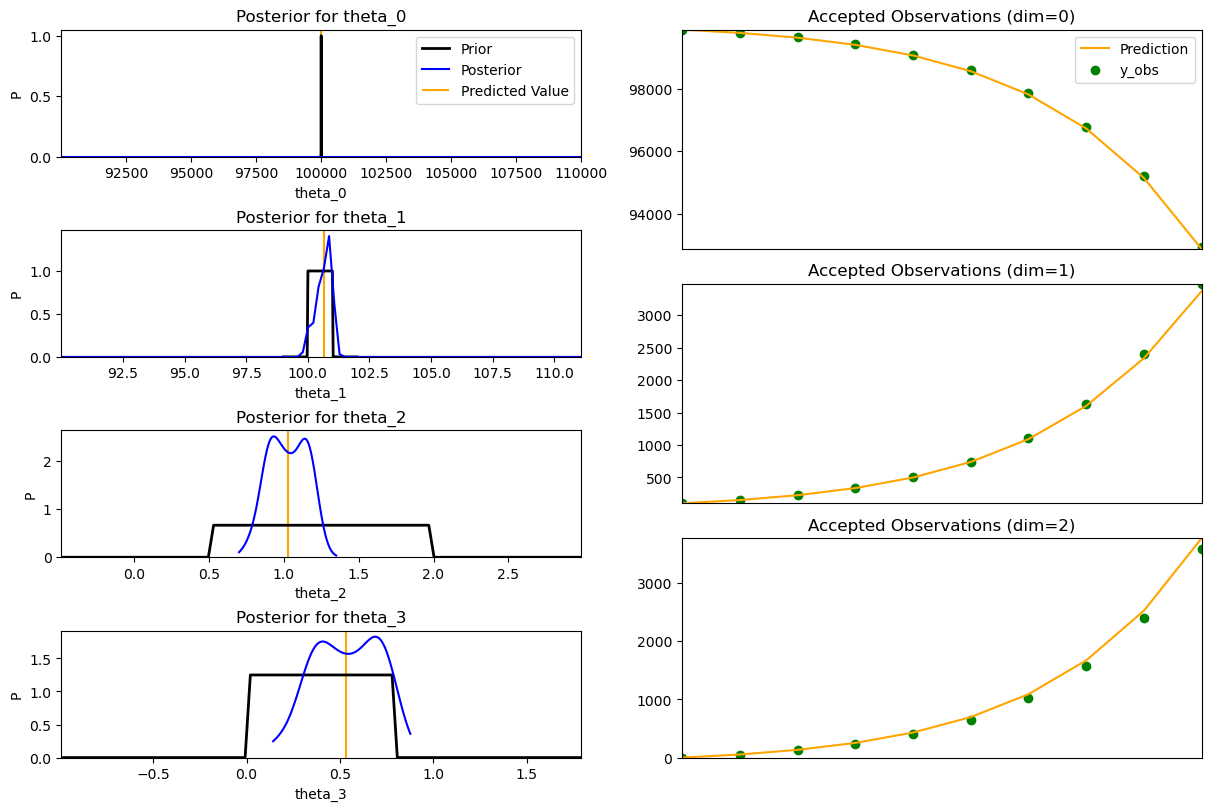

Wall time: 5min 18s


In [72]:
%%time
fitted_model_semi_10,accepted_params_semi_10,weights_semi_10=fit_truncated_model_with_semi_auto(sir_model,10)

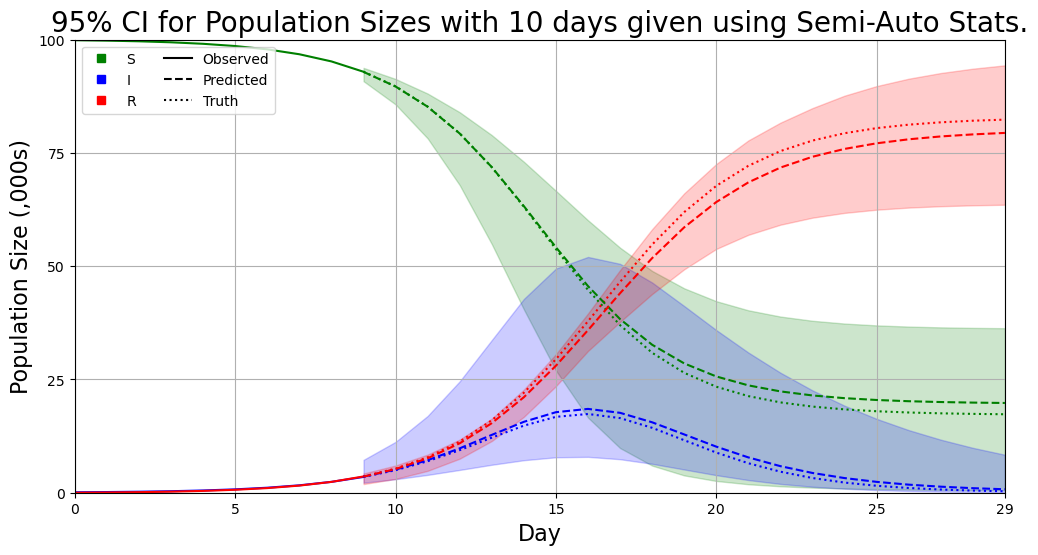

95% CI for R0: [1.544,3.071]


In [94]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_model_projection(ax,sir_model,10,accepted_params_semi_10,weights_semi_10,alpha=.05)

ax.set_title("95% CI for Population Sizes with 10 days given using Semi-Auto Stats.",fontsize=20)

plt.grid()
plt.show()

r0_ci=estimate_r0(accepted_params_semi_10,interval_width=.95)
print("95% CI for R0: [{:.3f},{:.3f}]".format(r0_ci[0],r0_ci[1]))

Calculated posteriors from pilot.                
Generated 500 parameter sets.
Generated summary statistics
[1.8405278480488996e-08, -4.9015815022332516e-11, 503.46743258158995, 323.3314212901248]
Summary Stats DONE

******************************************

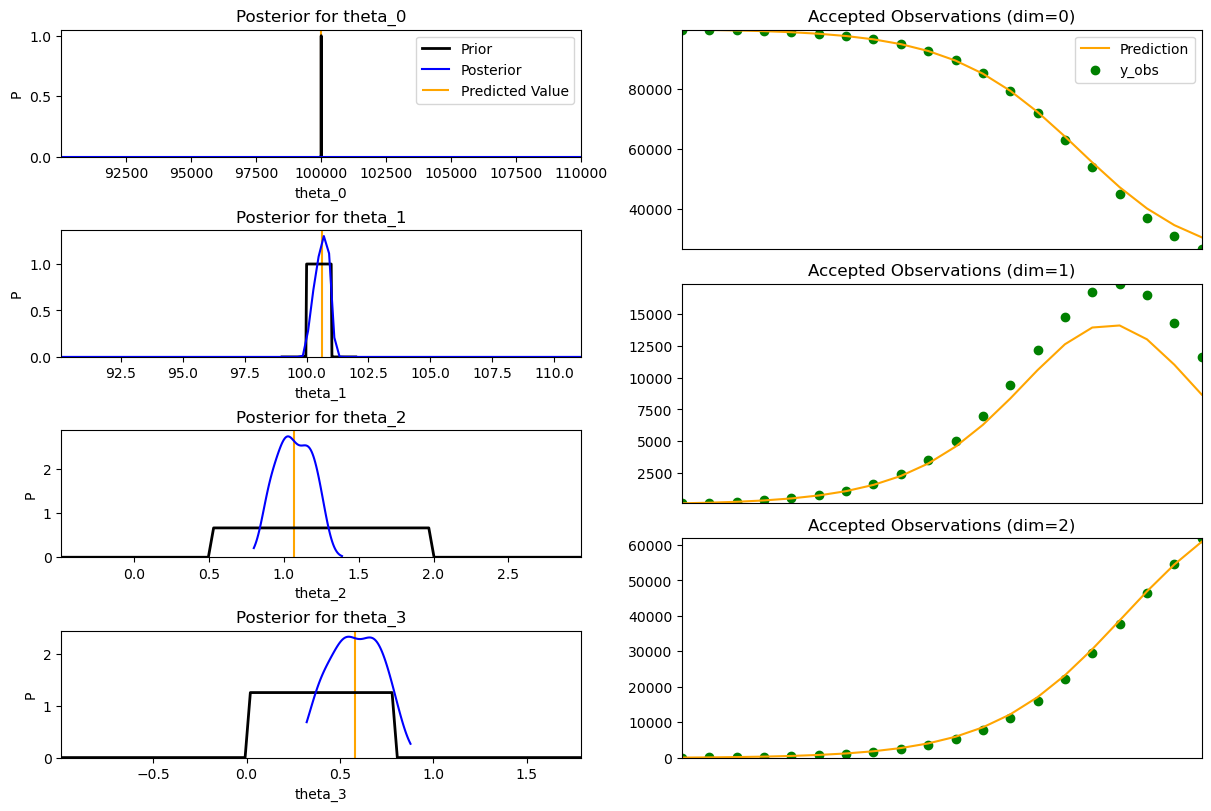

Wall time: 5min


In [78]:
%%time
fitted_model_semi_20,accepted_params_semi_20,weights_semi_20=fit_truncated_model_with_semi_auto(sir_model,20)

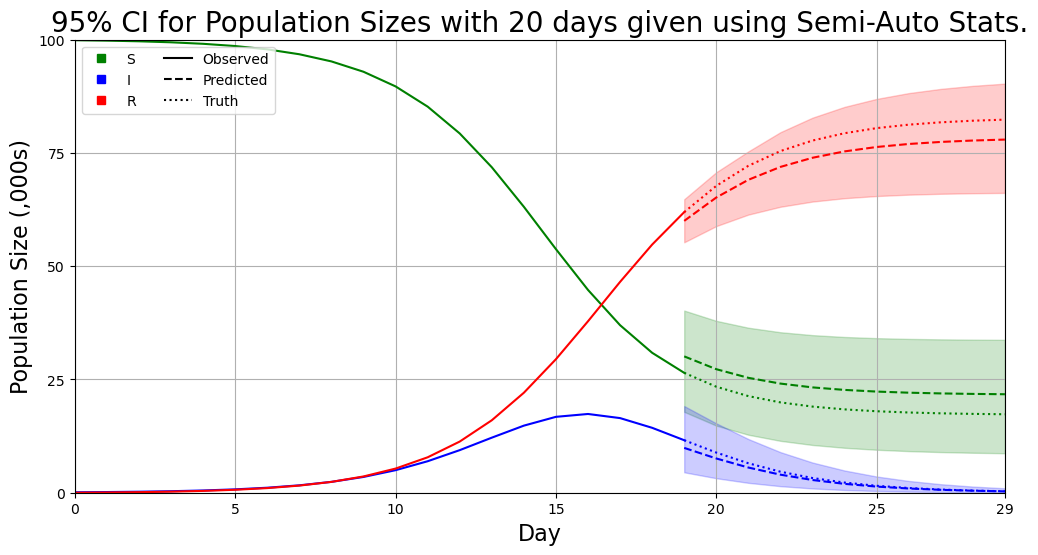

95% CI for R0: [1.582,2.407]


In [93]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_model_projection(ax,sir_model,20,accepted_params_semi_20,weights_semi_20,alpha=.05)

ax.set_title("95% CI for Population Sizes with 20 days given using Semi-Auto Stats.",fontsize=20)

plt.grid()
plt.show()

r0_ci=estimate_r0(accepted_params_semi_20,interval_width=.95)
print("95% CI for R0: [{:.3f},{:.3f}]".format(r0_ci[0],r0_ci[1]))

Calculated posteriors from pilot.                
Generated 500 parameter sets.
Generated summary statistics
[9.938669144640504e-08, -7.422678316057686e-11, 2276.3476286291184, 143.43120545164567]
Summary Stats DONE

***********************************************

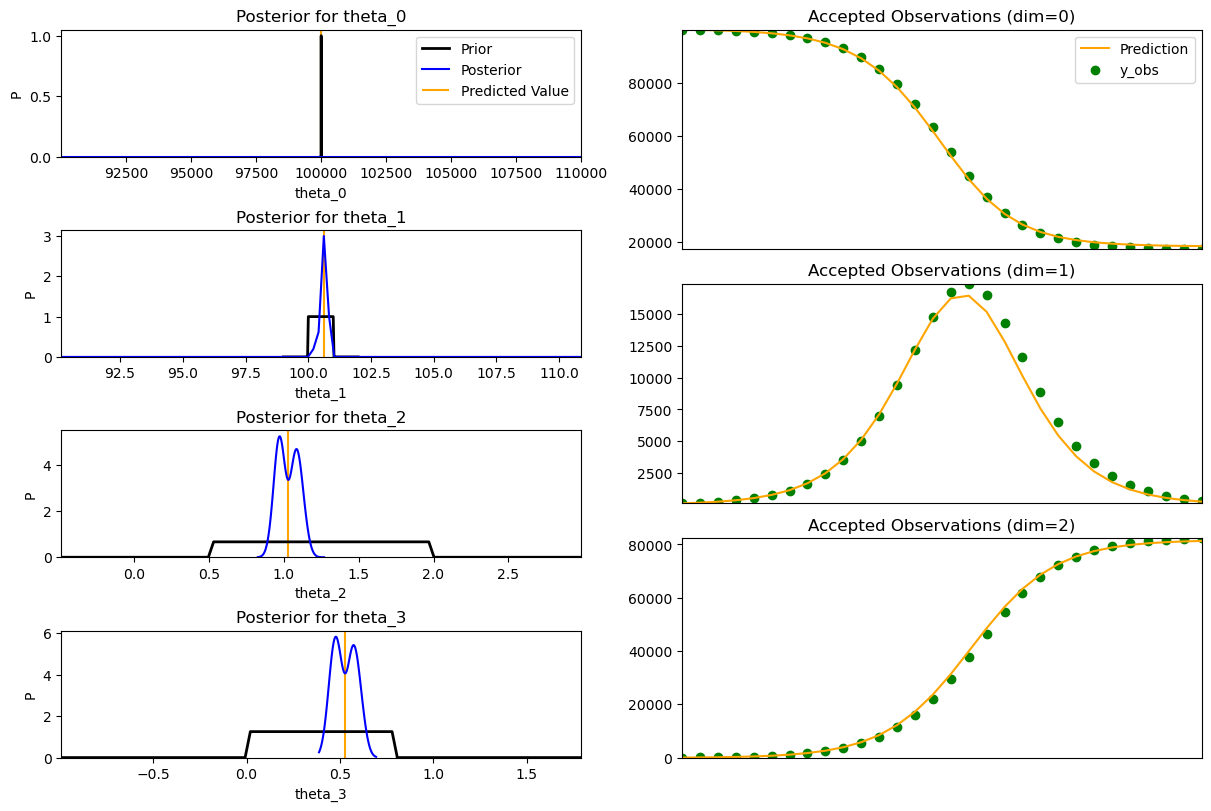

Wall time: 5min 36s


In [87]:
%%time
fitted_model_semi_0,accepted_params_semi_0,weights_semi_0=fit_truncated_model_with_semi_auto(sir_model,30)

In [89]:
flat_obs_1=[x for row in fitted_model_semi_0.observe() for x in row]
flat_obs_2=[x for row in sir_model.observe() for x in row]

new_e=mse(flat_obs_1,flat_obs_2)
print(new_e)

643255.1803262231


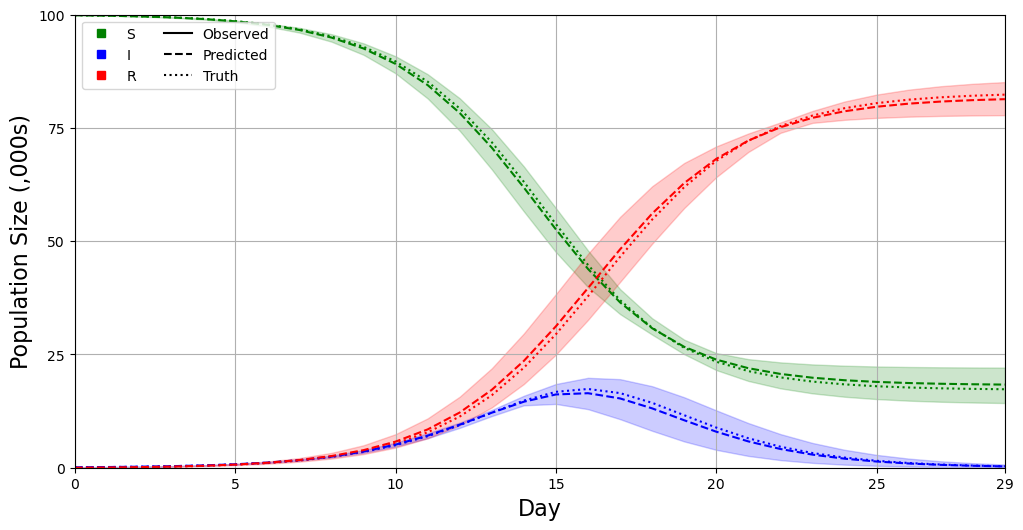

95% CI for R0: [1.847,2.127]


In [108]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_model_projection(ax,sir_model,1,accepted_params_semi_0,weights_semi_0,alpha=.05)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

r0_ci=estimate_r0(accepted_params_semi_0,interval_width=.95)
print("95% CI for R0: [{:.3f},{:.3f}]".format(r0_ci[0],r0_ci[1]))

****************************************************

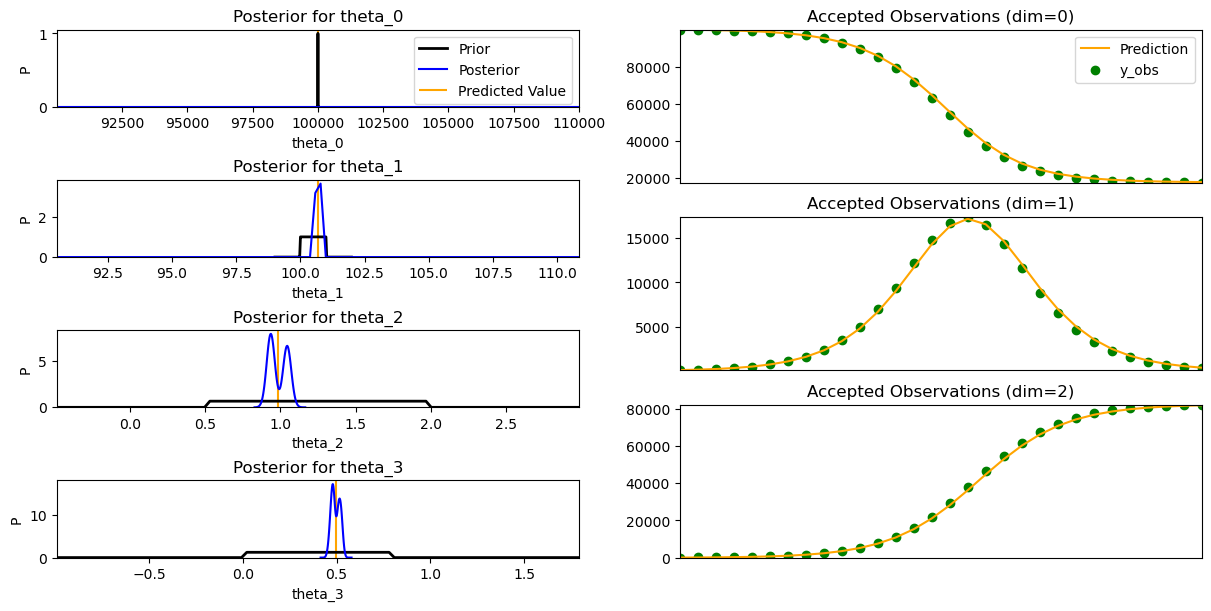

In [118]:
sir_smc_priors=[stats.uniform(100000,1),stats.uniform(100,1),stats.uniform(0.5,1.5),stats.uniform(0,.8)]

summary_stats=[peak_infections_value_ss,mean_infectious_ss,mean_removed_ss]

fitted_model_me_2,accepted_params_me_2,weights_me_2=ABC.adaptive_abc_smc(n_obs=30,y_obs=sir_model.observe(),
    fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
    max_steps=100,sample_size=50,max_simulations=3000,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,
    summary_stats=summary_stats,
    distance_measure=ABC.log_l2_norm,show_plots=True,printing=False)

In [119]:
flat_obs_1=[x for row in fitted_model_me_2.observe() for x in row]
flat_obs_2=[x for row in sir_model.observe() for x in row]

new_e=mse(flat_obs_1,flat_obs_2)
print(new_e)

492913.3274718888


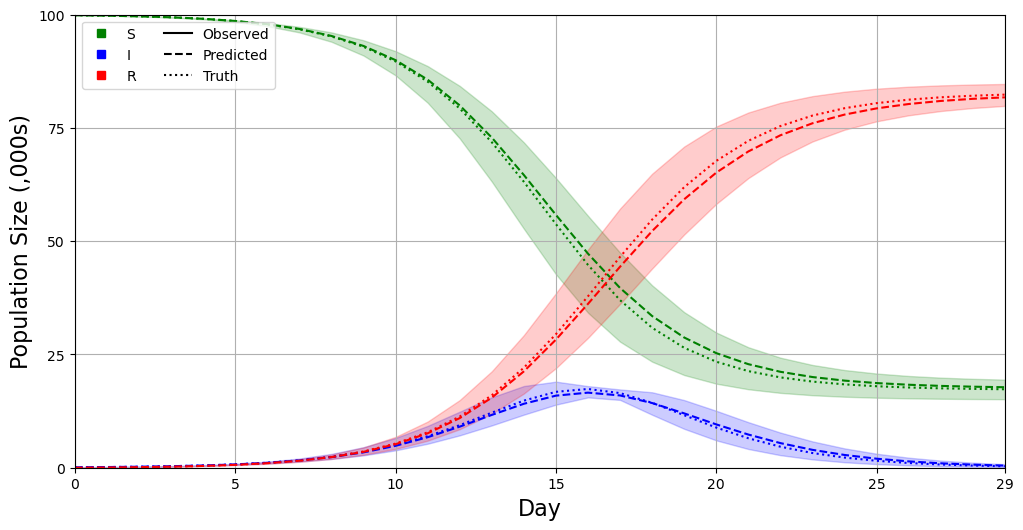

95% CI for R0: [1.944,2.073]


In [120]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_model_projection(ax,sir_model,1,accepted_params_me_2,weights_me_2,alpha=.05)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

r0_ci=estimate_r0(accepted_params_me_2,interval_width=.95)
print("95% CI for R0: [{:.3f},{:.3f}]".format(r0_ci[0],r0_ci[1]))